In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
pdf_path = "mcs2024.pdf"

## Extract the material lists

In [2]:
df = extract_word_positions(pdf_path, 0)
complexe_df = complexe_word(df, 2)

complexe_df.sample(2)

,text,x0,x1,top,doctop,bottom,upright,height,width,direction
10,Aluminum,74.31,123.64,343.578,343.578,355.578,True,12.0,49.332,ltr
77,Yttrium,439.84,475.18,573.930,573.930,585.930,True,12.0,35.340,ltr


In [3]:
result_df = extract_cols(complexe_df, 'x0', 2)

In [4]:
result_df['max_top'].min()

np.float64(329.12999999999954)

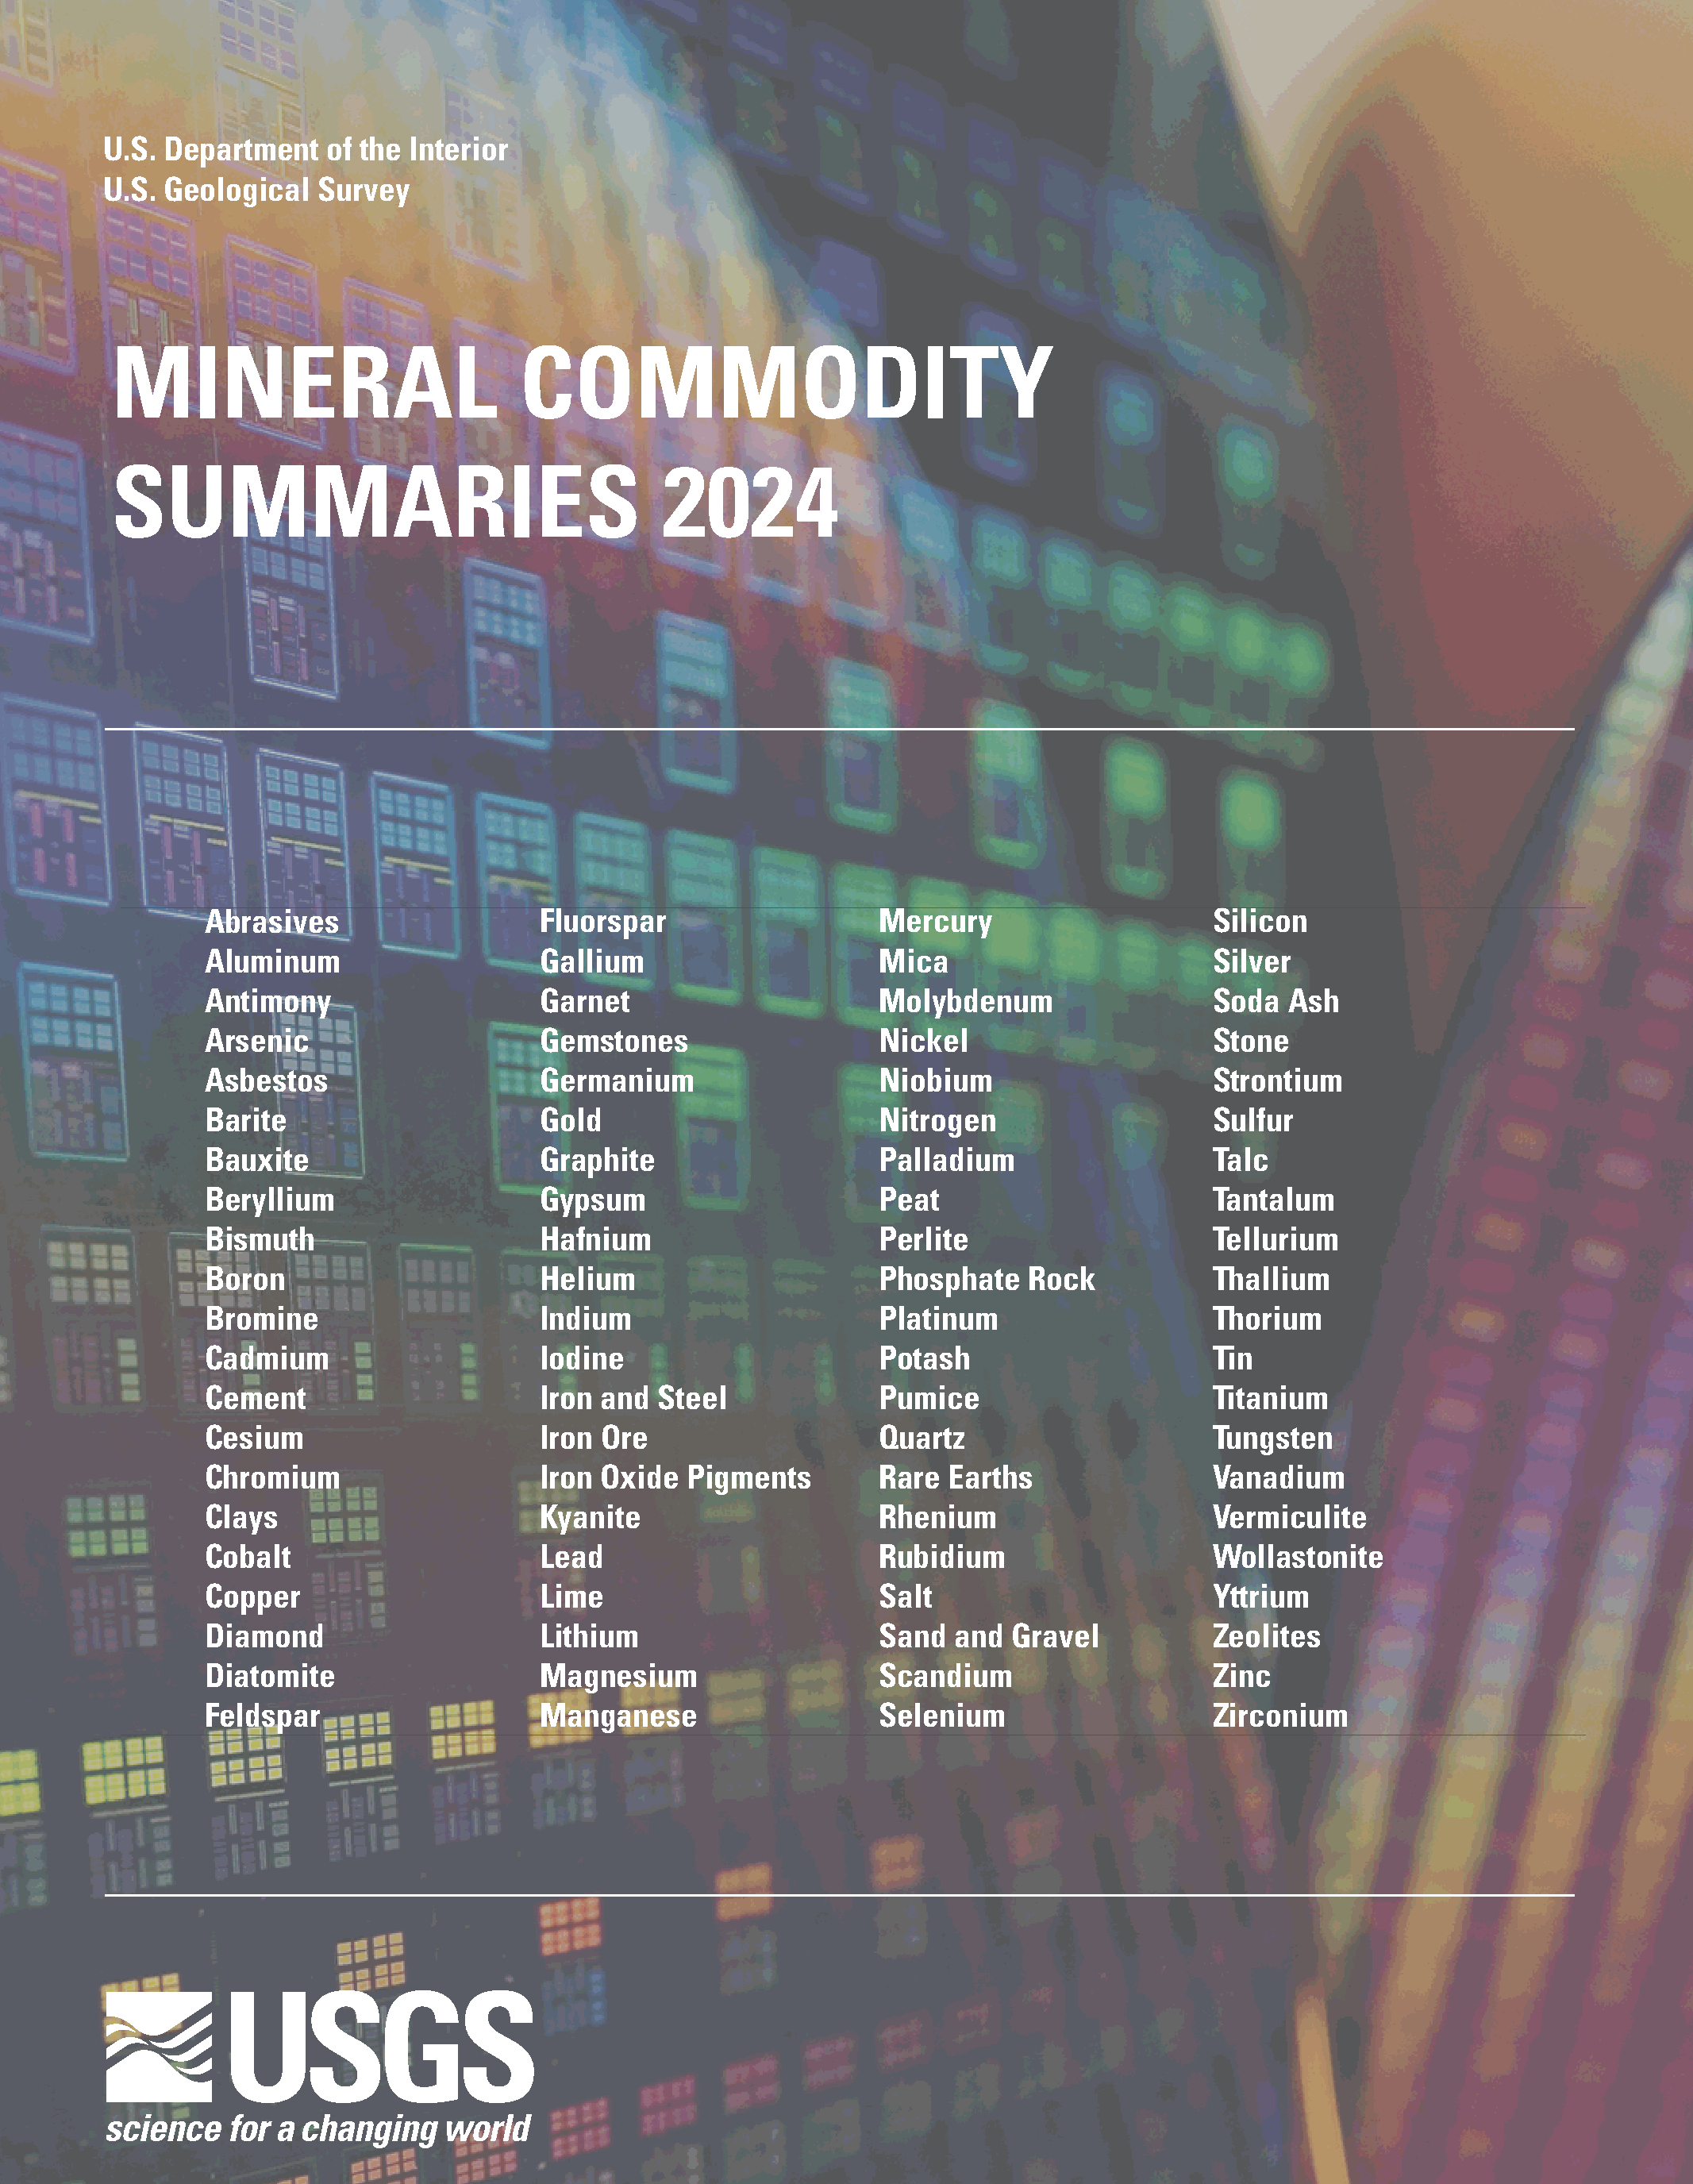

In [5]:
import pdfplumber

with pdfplumber.open("mcs2024.pdf") as pdf:
    im = pdf.pages[0].to_image(resolution=250)

im.draw_line([(575, result_df['max_top'].min()), (44, result_df['max_top'].min())], )
im.draw_line([(575, result_df['min_bottom'].max()), (44, result_df['min_bottom'].max())], )

In [6]:
materials_list = complexe_df[(complexe_df['top'] > int(result_df['max_top'].min())) & (complexe_df['bottom'] < 630)]['text'].tolist()

In [7]:
with open('json_files/materials_list.json', 'r') as json_file:
    materials_list = json.load(json_file)

## Match each material with its pages

In [8]:
# Ouvrir le PDF
elements = materials_list
l = []

with pdfplumber.open(pdf_path) as pdf:
    # Dictionnaire pour stocker les pages correspondant à chaque élément
    pdf_sections = {material: {'title': pd.DataFrame(), 'pages': []} for material in materials_list}
    
    # Parcourir chaque page du PDF
    for i in range(33, 209):

        # page = pdf.pages[i]
        largest_text = extract_largest_text(pdf_path, i)['text'].to_list()
        # l += largest_text

        for text in largest_text:
            matched_element = match_element_in_text(materials_list, text)
            if matched_element:
                pdf_sections[matched_element]['title'] = pd.concat([pdf_sections[matched_element]['title'], extract_largest_text(pdf_path, i)], ignore_index=True)
                pdf_sections[matched_element]['pages'].append(i + 1)

In [9]:
empty_pages_elements = [material for material, details in pdf_sections.items() if not details['pages']]

excluded_elements = {'Palladium'}
empty_pages_elements = list(set(empty_pages_elements) - excluded_elements)

empty_pages_elements

['Zirconium']

In [10]:
one_page_elements = [material for material, details in pdf_sections.items() if len(details['pages']) == 1]

one_page_elements

[]

In [11]:
three_page_elements = [material for material, details in pdf_sections.items() if len(details['pages']) == 3]

three_page_elements

[]

In [12]:
four_page_elements = [material for material, details in pdf_sections.items() if len(details['pages']) == 4]

four_page_elements

['Stone', 'Titanium', 'Sand and Gravel', 'Magnesium']

In [13]:
pdf_sections['Sand and Gravel']['title']

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,page
0,SAND AND GRAVEL (CONSTRUCTION)1,191.5,420.5,35.82048,120454.15404,49.332,True,13.51152,229.0,ltr,155
1,SAND AND GRAVEL (CONSTRUCTION),193.7,418.3,37.45200,121247.78556,49.452,True,12.00000,224.6,ltr,156
2,SAND AND GRAVEL (INDUSTRIAL)1,203.5,408.6,35.82048,122038.15404,49.332,True,13.51152,205.1,ltr,157
3,SAND AND GRAVEL (INDUSTRIAL),205.7,406.4,37.45200,122831.78556,49.452,True,12.00000,200.7,ltr,158


## Dictionary: 

{material_name: {
'material_title': df(title, bounding box),
'pages_num': [page1, page2],
'pages_content': [dataframe1, dataframe2],
  'remarks': [remark_df],
  'tables': [[tables_1(table + bounding_box)], [tables_2(table + bounding_box)]]
  }
}

In [15]:
type(pdf_sections['Abrasives']['title'])

pandas.core.frame.DataFrame

In [16]:
scraping_base = extract_positions_for_elements(pdf_path, pdf_sections)

## Remark extraction

In [17]:
scraping_base_bricolage = {k: v for k, v in list(scraping_base.items()) if k != 'Palladium' and k != 'Zirconium'}

In [18]:
for material, data in scraping_base_bricolage.items():
    # Ensure pages_content is not empty
    if data['pages_content']:
        # print(f" ▶️ {data['pages_content'][0]}")
        remarks = extract_text_between_delimiters(data['pages_content'][0], pdf_path, data['pages_num'][0])
        data['remarks'] = remarks
    else:
        print(f" ▶️ No pages_content for material: {material}")
    
    data['remarks'] = data['remarks'].drop_duplicates(subset=['text'])

In [19]:
data['remarks'].columns, data['pages_content'][0].columns

(Index(['text', 'x0', 'x1', 'top', 'bottom', 'doctop', 'upright', 'height',
        'width', 'direction', 'page'],
       dtype='object'),
 Index(['text', 'x0', 'x1', 'top', 'doctop', 'bottom', 'upright', 'height',
        'width', 'direction'],
       dtype='object'))

## Table extraction

In [20]:
with open('json_files/scraping_base.json', 'r', encoding='utf-8') as json_file:
    loaded_scraping_base = json.load(json_file)

# Convert serialized dictionaries back to DataFrames
def convert_dict_to_df(d):
    if isinstance(d, list) and all(isinstance(i, dict) for i in d):
        return pd.DataFrame(d)
    elif isinstance(d, list):
        return [convert_dict_to_df(i) for i in d]
    elif isinstance(d, dict):
        return {k: convert_dict_to_df(v) for k, v in d.items()}
    else:
        return d

scraping_base = convert_dict_to_df(loaded_scraping_base)

In [21]:
for material in list(scraping_base.keys()):
  scraping_base[material]['tables'] = []

In [22]:
import pandas as pd
import warnings

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'method' keyword in Series.replace is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning, message="Calling float on a single element Series is deprecated")

mt = 3

for material in list(scraping_base.keys()):
    if isinstance(scraping_base[material]['tables'], pd.DataFrame):
        scraping_base[material]['tables'] = scraping_base[material]['tables'].to_dict(orient='records')
    else:
        scraping_base[material]['tables'] = []

    selected_ps, contents = scraping_base[material]['pages_num'], scraping_base[material]['pages_content']
    i = 0

    for selected_p in selected_ps:
        content = contents[i]
        i += 1
        result = extract_table(selected_p - 1, content, mt)
        if result is None or len(result[0]) == 0:
            continue

        list_of_table_df, list_of_bbox, page = result
        table_dfs = table_to_df(list_of_table_df, list_of_bbox, page, pdf_path)
        if not table_dfs:
            continue

        for table_df, bbox in zip(table_dfs, list_of_bbox):
            table = table_df.sort_values('bottom')
            scraping_base[material]['tables'].append((table.to_dict(orient='records'), bbox, page))

In [23]:
def convert_df_to_dict(d):
    if isinstance(d, pd.DataFrame):
        return d.to_dict(orient='records')
    elif isinstance(d, list):
        return [convert_df_to_dict(i) for i in d]
    elif isinstance(d, dict):
        return {k: convert_df_to_dict(v) for k, v in d.items()}
    else:
        return d

serializable_scraping_base = convert_df_to_dict(scraping_base)

# Save the dictionary to a JSON file
with open('json_files/scraping_base_with_tables.json', 'w', encoding='utf-8') as json_file:
    json.dump(serializable_scraping_base, json_file, ensure_ascii=False, indent=4)

## Dictionary to excel

In [24]:
with open('json_files/scraping_base_with_tables.json', 'r', encoding='utf-8') as json_file:
    loaded_scraping_base = json.load(json_file)

# Convert serialized dictionaries back to DataFrames
def convert_dict_to_df(d):
    if isinstance(d, list) and all(isinstance(i, dict) for i in d):
        return pd.DataFrame(d)
    elif isinstance(d, list):
        return [convert_dict_to_df(i) for i in d]
    elif isinstance(d, dict):
        return {k: convert_dict_to_df(v) for k, v in d.items()}
    else:
        return d

scraping_base = convert_dict_to_df(loaded_scraping_base)

In [25]:
for material in list(scraping_base.keys()):
    for i in range(len(scraping_base[material]['tables'])):
        table, bbox, page = scraping_base[material]['tables'][i]
        table = table.sort_values('bottom')
        table = table.drop('bottom', axis=1)
        scraping_base[material]['tables'][i][0] = table 

In [26]:
with pd.ExcelWriter('excel_output/all_extracted_tables.xlsx', engine='openpyxl') as writer:
    for material, data in scraping_base.items():

        # Write remarks and tables in the same sheet, but separated by columns
        combined_sheet_name = f"{material}_raw_info"
        
        # Write remarks
        remarks_df = data['remarks'][['text']]
        remarks_df.columns = ['remark']
        remarks_df.to_excel(writer, sheet_name=combined_sheet_name, startrow=0, startcol=0, index=False)

        # Write each table starting from a new column
        start_col = len(remarks_df.columns) + 2  # Adding 2 for separation
        for i, (table_df, bbox, page) in enumerate(data['tables']):
            table_df.to_excel(writer, sheet_name=combined_sheet_name, startrow=0, startcol=start_col, index=False)
            # Increment start_col by the number of columns in the table + 2 for separation
            start_col += len(table_df.columns) + 2

print("Excel file created successfully.")

Excel file created successfully.


In [27]:
remarks_df

,remark
0,"(Data in metric tons, selenium content, unless..."


## PDF visualisation V1

In [28]:
scraping_base_bricolage = {k: v for k, v in list(scraping_base.items()) if k != 'Palladium' and k != 'Zirconium'}

In [29]:
output_pdf_path = 'pdf_output/mcs2024_data_all_tables.pdf'

draw_rectangles_for_materials(pdf_path, output_pdf_path, scraping_base_bricolage)

print(f"Rectangles drawn for materials in {pdf_path} and saved to {output_pdf_path}.")

Rectangles drawn for materials in mcs2024.pdf and saved to pdf_output/mcs2024_data_all_tables.pdf.


## Keep useful table in pdf and excel

In [30]:
def convert_dict_to_df(d):
    for key, value in d.items():
        if isinstance(value, dict):
            d[key] = convert_dict_to_df(value)
        elif isinstance(value, list):
            if all(isinstance(item, dict) for item in value):
                d[key] = pd.DataFrame(value)
            else:
                d[key] = [convert_dict_to_df(item) if isinstance(item, dict) else item for item in value]
    return d

In [31]:
def table_contains_target_phrases(table, target_phrases):
    return any(any(phrase.lower() in str(cell).lower() for cell in row) for row in table.values for phrase in target_phrases)

# Load the JSON file
with open('json_files/scraping_base_with_tables.json', 'r', encoding='utf-8') as json_file:
    loaded_scraping_base = json.load(json_file)

# Convert dictionary to DataFrame where applicable
scraping_base = convert_dict_to_df(loaded_scraping_base)

In [32]:
# Target phrases
target_phrases = ['World total (rounded)', 'World total']


# Filter the tables
for material in scraping_base.keys():
    new_dfs = []
    for table_data in scraping_base[material]['tables']:
        table, bbox, page = table_data
        df = pd.DataFrame(table)
        # Check if any cell in the dataframe matches the target phrases
        if df.apply(lambda row: any(match_element_in_text(target_phrases, str(cell)) for cell in row), axis=1).any():
            new_dfs.append(table_data)

        # if isinstance(table, pd.DataFrame) and table_contains_target_phrases(table, target_phrases):
        #     filtered_tables.append(table_data)
    
    # Update the 'tables' key with the filtered tables
    scraping_base[material]['tables'] = new_dfs     

# Save the filtered data as a new JSON file
with open('json_files/scraping_base_with_needed_tables.json', 'w', encoding='utf-8') as json_file:
    json.dump(scraping_base, json_file, indent=2, default=lambda x: x.to_dict() if isinstance(x, pd.DataFrame) else str(x))

print("Filtered JSON file created successfully.")

Filtered JSON file created successfully.


In [33]:
with open('json_files/scraping_base_with_needed_tables.json', 'r', encoding='utf-8') as json_file:
    loaded_scraping_base = json.load(json_file)

scraping_base = convert_dict_to_df(loaded_scraping_base)

In [34]:
for material in list(scraping_base.keys()):
    if 'remarks' in scraping_base[material]:
        remarks = scraping_base[material]['remarks']
        remarks_df = pd.DataFrame(remarks)
        scraping_base[material]['remarks'] = remarks_df

    if 'tables' in scraping_base[material]:    
        for i in range(len(scraping_base[material]['tables'])):
            table, bbox, page = scraping_base[material]['tables'][i]
            # Convert table to DataFrame
            df = pd.DataFrame(table)
            # Sort and drop 'bottom' column if it exists
            if 'bottom' in df.columns:
                df = df.sort_values('bottom')
                df = df.drop('bottom', axis=1)
            scraping_base[material]['tables'][i][0] = df

with pd.ExcelWriter('excel_output/production_reserve_tables1.xlsx', engine='openpyxl') as writer:
    for material, data in scraping_base.items():
        # print(f"🟠data: {data['remarks']}")
        # Write remarks and tables in the same sheet, but separated by columns
        combined_sheet_name = f"{material}_raw_info"
        
        # Write remarks
        remarks_df = data['remarks'][['text']]
        # print('🟠remark_df:', remarks_df)
        remarks_df.columns = ['remark']
        remarks_df.to_excel(writer, sheet_name=combined_sheet_name, startrow=0, startcol=0, index=False)

        # Write each table starting from a new column
        start_col = len(remarks_df.columns) + 2  # Adding 2 for separation
        for i, (table_df, bbox, page) in enumerate(data['tables']):
            table_df.to_excel(writer, sheet_name=combined_sheet_name, startrow=0, startcol=start_col, index=False)
            # Increment start_col by the number of columns in the table + 2 for separation
            start_col += len(table_df.columns) + 2

print("Excel file created successfully.")

Excel file created successfully.


In [35]:
with open('json_files/scraping_base_with_needed_tables.json', 'r', encoding='utf-8') as json_file:
# with open('json_files/scraping_base_with_tables.json', 'r', encoding='utf-8') as json_file:
    loaded_scraping_base = json.load(json_file)

scraping_base = convert_dict_to_df(loaded_scraping_base)

scraping_base_bricolage = {k: v for k, v in list(scraping_base.items()) if k != 'Palladium' and k != 'Zirconium'}

output_pdf_path = 'pdf_output/mcs2024_data_prod_reserve_tables.pdf'

draw_rectangles_for_materials(pdf_path, output_pdf_path, scraping_base_bricolage)

print(f"Rectangles drawn for materials in {pdf_path} and saved to {output_pdf_path}.")

Rectangles drawn for materials in mcs2024.pdf and saved to pdf_output/mcs2024_data_prod_reserve_tables.pdf.


## remark interpretation

In [93]:
excel_input = 'excel_output\production_reserve_tables1_updated_manualy.xlsx'

import json

with open('json_files/scraping_base.json', 'r', encoding='utf-8') as json_file:
    loaded_scraping_base = json.load(json_file)

scraping_base = convert_dict_to_df(loaded_scraping_base)

In [94]:
material_remarks = {material: {'remarks': content['remarks'][['text']]} for material, content in scraping_base.items()}

In [95]:
metric_conversion_df = pd.read_csv('sub_materials_database.csv\sub_materials_database_metric_conversion_factor.csv')

chem_compo_df = pd.read_csv('sub_materials_database.csv\sub_materials_database_sub_materials_database.csv')

In [96]:
def process_conversion_factor(value):
    if isinstance(value, str):
        if 'Not applicable' in value:
            return value
        # Extract numeric values using regex
        match = re.search(r'([-+]?\d*\.\d+|\d+)', value)
        if match:
            return float(match.group())
    return value

metric_conversion_df['conversion_factor'] = metric_conversion_df['conversion_factor'].apply(process_conversion_factor)

In [97]:
metric_conversion_df[5:10]

,Metric Mentioned,conversion_factor
5,Carat (diamond),0.0
6,Flask (fl),0.03447
7,Karat (gold),"Not applicable (a fraction, not a weight)"
8,Long ton (lt),101605.0
9,Long ton unit (ltu),0.01124


In [98]:
# First, set all 'final_unit' values to 't'
metric_conversion_df['final_unit'] = 't'

# Then, update 'final_unit' to 'karat' only for 'Karat (gold)'
metric_conversion_df.loc[metric_conversion_df['Metric Mentioned'] == 'Karat (gold)', 'final_unit'] = 'karat'
metric_conversion_df.loc[metric_conversion_df['Metric Mentioned'] == 'Mcf (1,000 cubic feet)', 'final_unit'] = 'cubic feet'
metric_conversion_df.loc[metric_conversion_df['Metric Mentioned'] == 'Psia', 'final_unit'] = 'P'

In [99]:
metric_conversion_df.head()

,Metric Mentioned,conversion_factor,final_unit
0,Kilogram,0.001,t
1,Thousand Metric Tons,1000.0,t
2,Metric Tons,1.0,t
3,Kilograms,0.001,t
4,Million Metric Tons,1000000.0,t


In [100]:
import pandas as pd
import shutil

# Copy the original Excel file to create an updated version
excel_output = 'excel_output/produc_reserve_remarkinterpre.xlsx'
shutil.copyfile(excel_input, excel_output)

# Open the Excel file for updating
with pd.ExcelWriter(excel_output, mode='a', if_sheet_exists='replace') as writer:
    for material in material_remarks.keys():
        # Convert the remarks to a DataFrame
        material_sample = pd.DataFrame(material_remarks[material]['remarks'], columns=['text'])

        # List of sub-material names from the reference_db
        materials_list = chem_compo_df['sub_material_name'].tolist()

        # List of metric units from the metric_conversion_df
        metrics_list = metric_conversion_df['Metric Mentioned'].tolist()

        # Apply the functions to the 'text' column of material_sample
        material_sample['chemical_composition'] = material_sample['text'].apply(
            lambda text: find_all_chemical_compositions(text, materials_list, chem_compo_df))
        material_sample['metric_conv_factor'] = material_sample['text'].apply(
            lambda text: find_metric_conversion_factor(text, metrics_list, metric_conversion_df))

        # Read the corresponding sheet from the original Excel file
        sheet_name = f"{material}_raw_info"
        original_df = pd.read_excel(excel_input, sheet_name=sheet_name)

        # Ensure the new DataFrame (material_sample) has the same index as the original_df
        material_sample = material_sample.reindex(original_df.index)

        # Insert the new columns next to the 'remark' column
        original_df.insert(1, 'chemical_composition', material_sample['chemical_composition'])
        original_df.insert(2, 'metric_conv_factor', material_sample['metric_conv_factor'])

        # Write the updated sheet back to the Excel file
        original_df.to_excel(writer, sheet_name=sheet_name, index=False)

## production of each material

In [101]:
excel_input = 'excel_output/produc_reserve_remarkinterpre.xlsx'

In [102]:
excel_file = pd.ExcelFile(excel_input)

# List to store dictionaries of sheet names and DataFrames
dfs = []

# Loop through all sheet names
for sheet_name in excel_file.sheet_names:
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Create a dictionary with sheet name and DataFrame
    sheet_dict = {
        f'sheet_name': sheet_name,
        f'df': df
    }
    
    # Append the dictionary to the list
    dfs.append(sheet_dict)

In [103]:
words_to_exclude = ['Reserves', 'Capacity', 'reserves', 'capacity']  # Add or remove elements as needed

def contains_excluded_word(column, excluded_words):
    def check_cell(cell):
        cell_str = str(cell).lower()
        return any(word.lower() in cell_str for word in excluded_words)
    
    return column.apply(check_cell).any()

In [104]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import re

def match_composition(input_name, reference_df):
    input_name = str(input_name).lower()
    best_match = None
    best_ratio = 0
    for material in reference_df['sub_material_name']:
        ratio = fuzz.partial_ratio(input_name, str(material).lower())
        if ratio > best_ratio:
            best_ratio = ratio
            best_match = material
    if best_ratio < 80:
        return None
    composition = reference_df.loc[reference_df['sub_material_name'] == best_match, 'chemical_composition'].iloc[0]
    return composition

def clean_numeric(val):
    if isinstance(val, str):
        cleaned = re.sub(r'[^\d.]+', '', val)
        return float(cleaned) if cleaned else np.nan
    return val

def convert_year_to_float(year):
    if isinstance(year, str):
        year = year.strip().lower()
        if year.endswith('e'):
            return float(year[:-1])
        try:
            return float(year)
        except ValueError:
            return np.nan
    return int(year) if pd.notnull(year) else np.nan

def process_column(df, text_df, title_row, index, item, years):
    for year in years:
        year_float = convert_year_to_float(year)
        if pd.notna(year_float):
            chem_comp_dict = item['chem_comp']
            if chem_comp_dict:
                for elem, percentage in chem_comp_dict.items():
                    new_col_name = f"{elem}_{year_float}"
                    try:
                        numeric_col = text_df.iloc[2:][title_row[index]].apply(clean_numeric)
                        result = numeric_col * percentage
                        result = result.replace([np.inf, -np.inf], np.nan)
                        if new_col_name in df.columns:
                            df[new_col_name] += result
                        else:
                            df[new_col_name] = pd.Series(index=df.index)
                            df.loc[df.index[2:], new_col_name] = result.values
                        print(f"Created/Updated column: {new_col_name}")
                    except Exception as e:
                        print(f"🔴Error processing column {title_row[index]}: {str(e)}")
            else:
                print(f"🔴 No valid chemical composition for {item['material']}. Keeping original data.")

def process_varied_composition(df, text_df, title_row, sheet_material, first_row, second_row):
    for index, col in enumerate(title_row):
        if text_df[col].iloc[2:].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna().any():
            years = second_row.iloc[index].split(',') if isinstance(second_row.iloc[index], str) else [second_row.iloc[index]]
            for year in years:
                year_float = convert_year_to_float(year)
                if pd.notna(year_float):
                    new_col_name = f"{sheet_material}_{year_float}"
                    try:
                        numeric_col = text_df.iloc[2:][col].apply(clean_numeric)
                        if new_col_name in df.columns:
                            df[new_col_name] += numeric_col
                        else:
                            df[new_col_name] = pd.Series(index=df.index)
                            df.loc[df.index[2:], new_col_name] = numeric_col.values
                        print(f"Created/Updated column: {new_col_name}")
                    except Exception as e:
                        print(f"🔴Error processing column {col}: {str(e)}")

materials_missing_comp = []
for i in range(0, len(dfs)):
    sheet_name = dfs[i]['sheet_name']
    df = dfs[i]['df'].copy()
    print("SHEET NAME : ", sheet_name)

    original_text_columns = [col for col in df.columns if col.startswith('text')]
    columns_to_keep = [col for col in df.columns if not contains_excluded_word(df[col], words_to_exclude)]
    df = df[columns_to_keep]
    remaining_text_columns = [col for col in df.columns if col.startswith('text')]

    if remaining_text_columns:
        text_df = df[remaining_text_columns]
        first_row = text_df.iloc[0] if not text_df.empty else pd.Series()
        second_row = text_df.iloc[1] if len(text_df) > 1 else pd.Series()
        title_row = list(text_df.columns)
        materials = list(pd.unique(first_row.dropna().values))

        list_chem_comp = []
        for material in materials:
            chem_comp = match_composition(material, chem_compo_df)
            list_chem_comp.append({"material": material, "chem_comp": chem_comp})

        if all(item['chem_comp'] is None for item in list_chem_comp):
            material = sheet_name.replace('_raw_info', '')
            list_chem_comp = [{"material": material, "chem_comp": match_composition(material, chem_compo_df)}]

        if all(item['chem_comp'] is None for item in list_chem_comp):
            materials_missing_comp.append(sheet_name.replace('_raw_info', ''))
            print("🧿 no match")
        else:
            list_chem_comp = convert_string_to_dict(list_chem_comp)
            df['chemical_composition'] = str(list_chem_comp)

            if list_chem_comp[0]['chem_comp'] != 'Varied':
                sheet_material = sheet_name.replace('_raw_info', '')
                is_sheet_material = any(item['material'] == sheet_material for item in list_chem_comp)

                if is_sheet_material:
                    for index, col in enumerate(title_row):
                        if text_df[col].iloc[2:].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna().any():
                            item = next((item for item in list_chem_comp if item['material'] == sheet_material), None)
                            if item:
                                years = second_row.iloc[index].split(',') if isinstance(second_row.iloc[index], str) else [second_row.iloc[index]]
                                process_column(df, text_df, title_row, index, item, years)
                else:
                    for index, col in enumerate(first_row):
                        for item in list_chem_comp:
                            if col == item['material']:
                                years = second_row.iloc[index].split(',') if isinstance(second_row.iloc[index], str) else [second_row.iloc[index]]
                                process_column(df, text_df, title_row, index, item, years)
                print('🟢 not varied')
            else:
                print('🟢 varied')
                sheet_material = sheet_name.replace('_raw_info', '')
                process_varied_composition(df, text_df, title_row, sheet_material, first_row, second_row)
                print("🟢🟢🟢🟢🟢 ===> ", sheet_material)
    else:
        print(f"No text columns remaining for sheet: {sheet_name}")

    print("=" * 50)
    print()

    dfs[i]['df'] = df

SHEET NAME :  Abrasives_raw_info
Created/Updated column: Al_2022.0
Created/Updated column: O_2022.0
Created/Updated column: Al_2023.0
Created/Updated column: O_2023.0
Created/Updated column: Si_2022.0
Created/Updated column: C_2022.0
Created/Updated column: Si_2023.0
Created/Updated column: C_2023.0
🟢 not varied

SHEET NAME :  Fluorspar_raw_info
Created/Updated column: Ca_2022.0
Created/Updated column: F_2022.0
Created/Updated column: Ca_2023.0
Created/Updated column: F_2023.0
🟢 not varied

SHEET NAME :  Mercury_raw_info
Created/Updated column: Hg_2022.0
Created/Updated column: Hg_2023.0
🟢 not varied

SHEET NAME :  Silicon_raw_info
Created/Updated column: Si_2022.0
Created/Updated column: Fe_2022.0
Created/Updated column: Si_2023.0
Created/Updated column: Fe_2023.0
Created/Updated column: Mg_2022.0
Created/Updated column: Si_2022.0
Created/Updated column: O_2022.0
Created/Updated column: Mg_2023.0
Created/Updated column: Si_2023.0
Created/Updated column: O_2023.0
🟢 not varied

SHEET NA

In [105]:
materials_missing_comp

['Tungsten']

In [106]:
# Sort the dfs list by sheet_name
dfs = sorted(dfs, key=lambda x: x['sheet_name'])

# Save all DataFrames to a single Excel file
output_file = 'excel_output/production_each_material.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for df_dict in dfs:
        sheet_name = df_dict['sheet_name']
        df = df_dict['df']
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All processed DataFrames have been saved to {output_file} with sheets sorted alphabetically.")

All processed DataFrames have been saved to excel_output/production_each_material.xlsx with sheets sorted alphabetically.


In [107]:
import pandas as pd
import numpy as np

def detect_post_text_columns(columns):
    last_text_index = max([i for i, col in enumerate(columns) if col.startswith('text')], default=-1)
    return columns[last_text_index + 1:] if last_text_index != -1 else []

def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

res_dfs = []

for i in range(0, len(dfs)-13):
    sheet_name = dfs[i]['sheet_name']
    df = dfs[i]['df'].copy()  # Create a copy to avoid SettingWithCopyWarning
    print("SHEET NAME : ", sheet_name)
    
    # Safely access conv_factor
    conv_factor = df['metric_conv_factor'].iloc[0] if 'metric_conv_factor' in df.columns else None
    cols = list(df.columns)
    post_text_columns = detect_post_text_columns(cols)

    if post_text_columns:
        data = df[['text'] + post_text_columns]
        data = data.dropna(how='all')

        if conv_factor is not None and not isinstance(conv_factor, str):
            try:
                conv_factor = float(conv_factor)
                for col in post_text_columns:
                    data[col] = data[col].apply(lambda x: x * conv_factor if is_numeric(x) else x)
                print(f"Applied conversion factor {conv_factor} to numerical values in {sheet_name}")
            except ValueError:
                print(f"Warning: Could not convert {conv_factor} to float in {sheet_name}")
        
        res_dfs.append(data)
    else:
        print(f"No post-text columns found in {sheet_name}")

# Merge all data(s) in res_dfs
if res_dfs:
    merged_df = pd.concat(res_dfs, keys=[f"Sheet_{i}" for i in range(len(res_dfs))], axis=0)
    print("All dataframes merged successfully")
else:
    merged_df = pd.DataFrame()
    print("No dataframes to merge")

SHEET NAME :  Abrasives_raw_info
Applied conversion factor nan to numerical values in Abrasives_raw_info
SHEET NAME :  Aluminum_raw_info
Applied conversion factor 1000.0 to numerical values in Aluminum_raw_info
SHEET NAME :  Antimony_raw_info
Applied conversion factor 1.0 to numerical values in Antimony_raw_info
SHEET NAME :  Arsenic_raw_info
Applied conversion factor 1.0 to numerical values in Arsenic_raw_info
SHEET NAME :  Asbestos_raw_info
No post-text columns found in Asbestos_raw_info
SHEET NAME :  Barite_raw_info
Applied conversion factor 1000.0 to numerical values in Barite_raw_info
SHEET NAME :  Bauxite_raw_info
Applied conversion factor 1000.0 to numerical values in Bauxite_raw_info
SHEET NAME :  Beryllium_raw_info
Applied conversion factor 1.0 to numerical values in Beryllium_raw_info
SHEET NAME :  Bismuth_raw_info
Applied conversion factor 1.0 to numerical values in Bismuth_raw_info
SHEET NAME :  Boron_raw_info
Applied conversion factor 1000.0 to numerical values in Boron_ra

In [108]:
merged_df.shape

(735, 90)

In [109]:
merged_df.columns

Index(['text', 'Al_2022.0', 'O_2022.0', 'Al_2023.0', 'O_2023.0', 'Si_2022.0',
       'C_2022.0', 'Si_2023.0', 'C_2023.0', 'Sb_2022.0', 'Sb_2023.0',
       'Arsenic_2022', 'Arsenic_2023', 'Ba_2022.0', 'S_2022.0', 'Ba_2023.0',
       'S_2023.0', 'Be_2022.0', 'Be_2023.0', 'Bi_2022.0', 'Bi_2023.0',
       'B_2022.0', 'B_2023.0', 'Cd_2022.0', 'Cd_2023.0', 'Ca_2022.0',
       'Fe_2022.0', 'Ca_2023.0', 'Fe_2023.0', 'Clays_2022', 'Clays_2023',
       'Co_2022.0', 'Co_2023.0', 'Cu_2022.0', 'Cu_2023.0', 'K_2022.0',
       'Na_2022.0', 'K_2023.0', 'Na_2023.0', 'F_2022.0', 'F_2023.0',
       'Mg_2023.0', 'Gemstones_2022.0', 'Gemstones_2023.0', 'Au_2022.0',
       'Au_2023.0', 'Zr_2022', 'Si_2022', 'O_2022', 'Zr_2023', 'Si_2023',
       'O_2023', 'He_2022.0', 'He_2023.0', 'Indium_2022.0', 'Indium_2023.0',
       'I_2022.0', 'I_2023.0', 'Fe_2022', 'Fe_2023', 'Mn_2022.0', 'P_2022.0',
       'Mn_2023.0', 'P_2023.0', 'Pb_2022.0', 'Pb_2023.0', 'Li_2023.0',
       'Mg_2022.0', 'Hg_2022.0', 'Hg_2023.0', '

In [110]:
merged_df.columns = merged_df.columns.str.replace(r'\.0$', '', regex=True)

In [111]:
len(merged_df['text'].unique())

163

In [112]:
merged_df['text'] = merged_df['text'].str.lower()
merged_df['text'] = merged_df['text'].str.replace(r'\d+', '', regex=True)

In [113]:
len(merged_df['text'].unique())

154

In [114]:
# First replace 'world total' with a common string
merged_df['text'] = merged_df['text'].str.replace(r'^world total.*', 'world total', regex=True, case=False)

# Remove any text between parentheses and strip leading/trailing spaces
merged_df['text'] = merged_df['text'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

In [115]:
len(merged_df['text'].unique())

134

In [116]:
merged_df['text'] = merged_df['text'].str.split(',', n=1).str[0].str.strip()

In [117]:
len(merged_df['text'].unique())

123

In [118]:
outliers = ['natural:', 'other', 'other countries']

# Remove rows where 'text' equals any value in the outliers list
merged_df = merged_df[~merged_df['text'].isin(outliers)]

In [119]:
len(merged_df['text'].unique())

121

In [120]:
merged_df_summed = merged_df.groupby('text', as_index=False).sum()


In [121]:
out_df = merged_df_summed.groupby(merged_df_summed.columns, axis=1).sum()

C:\Users\DataScience\AppData\Local\Temp\ipykernel_46480\3528072658.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  out_df = merged_df_summed.groupby(merged_df_summed.columns, axis=1).sum()


In [122]:
import pandas as pd
from fuzzywuzzy import process

# List of standard country names
countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia", "Australia", 
    "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", 
    "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", 
    "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia", 
    "Comoros", "Congo", "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czech Republic", "Democratic Republic of the Congo", 
    "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", 
    "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", 
    "Ghana", "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", 
    "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland", "Israel", "Italy", "Ivory Coast", "Jamaica", "Japan", 
    "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", 
    "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", 
    "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", 
    "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", 
    "Nigeria", "North Korea", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau", "Palestine", "Panama", 
    "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", 
    "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", 
    "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", 
    "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka", "Sudan", 
    "Suriname", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste", "Togo", 
    "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", 
    "United Arab Emirates", "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican City", 
    "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
]

def match_country(country, choices, cutoff=80):
    match = process.extractOne(country, choices, score_cutoff=cutoff)
    return match[0] if match else country

# Apply the matching function to the 'text' column
out_df['text'] = out_df['text'].apply(lambda x: match_country(x, countries) if x != 'world total' and x != 'calculated world total' else x)

# Group by the standardized names and sum the numeric columns
out_df = out_df.groupby('text', as_index=False).sum()

# Recalculate the world total
world_total_row = out_df[out_df['text'] == 'world total']
other_rows = out_df[out_df['text'] != 'world total']

calculated_world_total = other_rows.select_dtypes(include=[np.number]).sum().to_frame().T
calculated_world_total['text'] = 'calculated world total'

# Combine the rows
out_df = pd.concat([other_rows, calculated_world_total], ignore_index=True)

# Sort the columns to ensure they are in the correct order
out_df = out_df.reindex(columns=['text'] + sorted([col for col in out_df.columns if col != 'text']))

# Reset the index
out_df = out_df.reset_index(drop=True)

In [123]:
# First, get the columns list with 'text' at the beginning
columns_order = ['text'] + [col for col in out_df.columns if col != 'text']

# Reorder the DataFrame columns
out_df = out_df[columns_order]

In [124]:
# Split out_df into 2022_df and 2023_df
columns_2022 = ['text'] + [col for col in out_df.columns if col.endswith('2022')]
columns_2023 = ['text'] + [col for col in out_df.columns if col.endswith('2023')]

# Create DataFrames for each year
df_22 = out_df[columns_2022]
df_23 = out_df[columns_2023]

# Save to Excel with two sheets
with pd.ExcelWriter('final_table.xlsx', engine='openpyxl') as writer:
    df_22.to_excel(writer, sheet_name='2022 Data', index=False)
    df_23.to_excel(writer, sheet_name='2023 Data', index=False)